# Imports

In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import ProbPlot
from yellowbrick.regressor import ResidualsPlot

plt.style.use('seaborn') 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import feature_selection
from sklearn import linear_model

In [80]:
#download train and test data via api
! kaggle competitions download -c titanic --force


  0%|          | 0.00/59.8k [00:00<?, ?B/s]
100%|##########| 59.8k/59.8k [00:00<?, ?B/s]

  0%|          | 0.00/28.0k [00:00<?, ?B/s]
100%|##########| 28.0k/28.0k [00:00<?, ?B/s]

  0%|          | 0.00/3.18k [00:00<?, ?B/s]
100%|##########| 3.18k/3.18k [00:00<00:00, 1.62MB/s]


In [81]:
def eda_grouper(groupby_var, df):
    new_df = df[df.data_type=='train'].groupby([groupby_var, 'survived']).passengerid.count().to_frame().reset_index()
    new_df.rename(columns={'passengerid':'passenger_count'}, inplace=True)
    new_df.survived = new_df.survived.apply(lambda r: 'yes' if r == 1 else 'no')


    return new_df

# Data Import

In [82]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [83]:
#add data_type columns before combine
train_df['data_type'] = 'train'
test_df['data_type'] = 'test'

#combine dataframes so that we can do transformations on train and test data simultaneously
df = pd.concat([train_df, test_df])
df.reset_index(inplace=True, drop=True)

#lower case all column names
df.columns = map(str.lower, df.columns)

# Data Quality Check

This is where we do a first pass at the data quality check, to ensure that the data are imported into dataframes correctly, and to get a general idea whether therea re missing data. For most part the data set that we received looked clean, save for a few exceptions below:

* There are 263 rows where the `age` value is missing.
* There are 2 rows where the `embarked` value is missing.
* There is 1 row with missing `fare` value.
* Majority of the rows have a missing `cabin` value.

For the missing values either we will have to either fill it in with a default value or machine learning to predict.

In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
age            1046 non-null float64
cabin          295 non-null object
embarked       1307 non-null object
fare           1308 non-null float64
name           1309 non-null object
parch          1309 non-null int64
passengerid    1309 non-null int64
pclass         1309 non-null int64
sex            1309 non-null object
sibsp          1309 non-null int64
survived       891 non-null float64
ticket         1309 non-null object
data_type      1309 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 133.0+ KB



# Exploratory Data Analysis/Feature Engineering

For ease we want to combine both the train and test dataframes. However for exploratory data analysis purposes we will only be using train data only to prevent any formation of bias.

## title

There seems to be titles that we can extract out of the names of the passengers that may be useful for our predictions. For example judging from bar graph below, 'Master' seems to refer to boys, thus title might be a useful variable to predict the missing age data points.

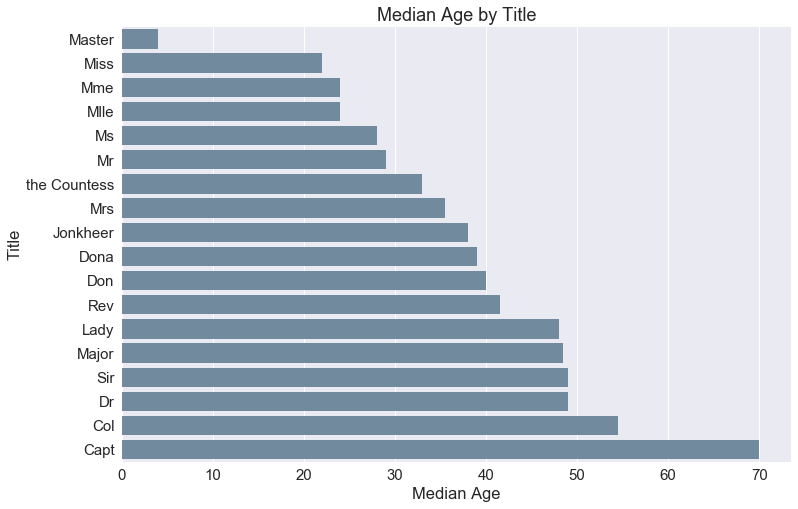

In [85]:
#extract title from the name column
df['title'] = df.name.str.extract(r',\ ([A-Za-z_ ]+)\.', expand=False)

#create dataframe for visualization
title_df = eda_grouper('title', df)

#bar plot for sex and survive counts
plt.figure(figsize=(12,8))
sns.set(font_scale=1.5)

ax = sns.barplot(x='age',
            y='title', 
            data=df.groupby('title').age.median().sort_values().to_frame().reset_index(),
            color='#6b8ba4')

ax = ax.set(xlabel='Median Age', ylabel='Title', title='Median Age by Title')

The bargraph below seems to show that boys and women generally have a higher survival rate than men. This may be due to the convention at the time of the incident where women and children are boarded first onto the lifeboats.

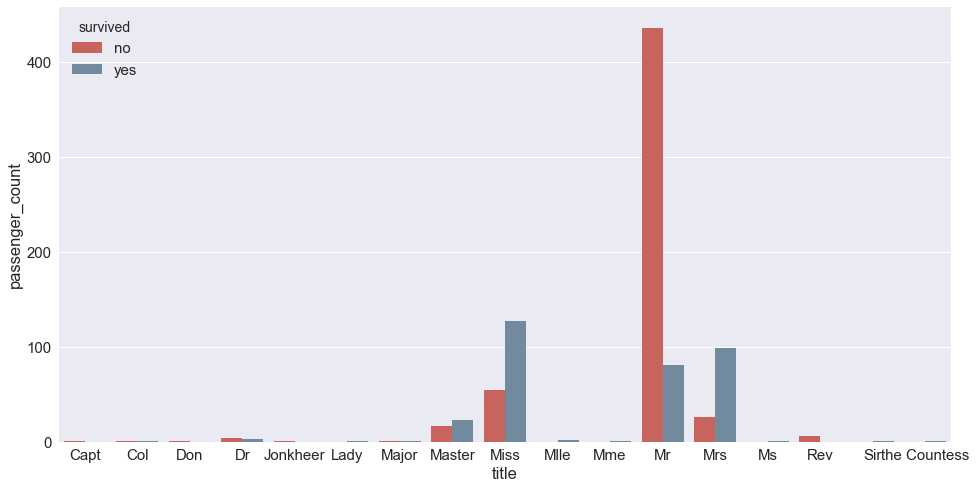

In [86]:
#extract title from the name column
df['title'] = df.name.str.extract(r',\ ([A-Za-z_ ]+)\.', expand=False)

title_df = eda_grouper('title', df)

#bar plot for sex and survive counts
plt.figure(figsize=(16,8))

sns.set(font_scale=1.5)

sns.barplot(x='title', y='passenger_count', hue='survived', data=title_df, palette=['#d9544d', '#6b8ba4'])

Since title is a categorical variable, to be able to make this variable included in the model, we will be dummify-ing it.

In [87]:
#dummify the title column
df = df.join(pd.get_dummies(df.title))

#dropping the title column
#train_df.drop('title', axis=1, inplace=True)

## sex

Plotting the `sex` and `survived` reinforces the finding above, where women tend to have a higher survival rate then men, specifically the older ones.  Another thing to note is that majority of the passengers seems to be male.

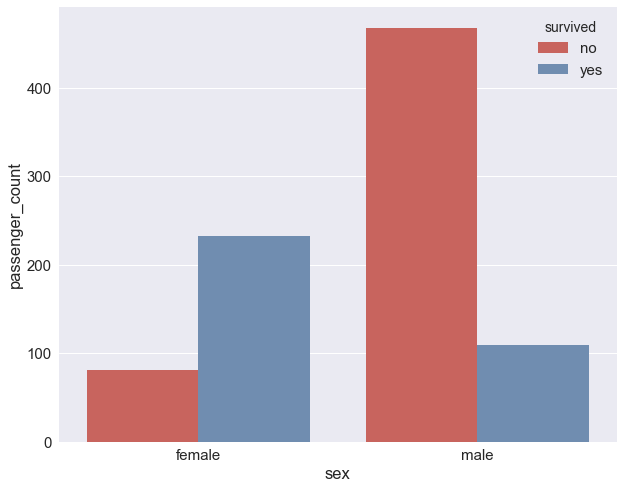

In [1109]:
#count passengers how many passengers survived and perished by sex.
sex_df = eda_grouper('sex', df)

#bar plot for sex and survive counts
plt.figure(figsize=(10,8))
sns.set(font_scale=1.5)
sns.barplot(x='sex', y='passenger_count', hue='survived', data=sex_df, palette=['#d9544d', '#658cbb'])

Like title, sex is also a categorical variable, so we need to dummify it to make it usable in our models.

In [ ]:
#dummify the sex column
df = df.join(pd.get_dummies(df.sex))

Since titles are gender specific, we need to check for high degree of multicollinearity between the title variables and the male/female variables as this may introduce more variance in the error terms. Based on the correlation heatmap, below are the findings:

* There is perfect multicollinearity between `male` and `female`, so we need to exclude one of them from the model. For the purpose of this exercise we will be excluding the `male` variable.
* There is high degree of of multicollinearity between `female` and `Mr`, which makes sense since majority of the men have a `Mr` title, so we will need to exclude the `Mr` variable from the models.
* There is also a high degree of multicolinearity between `female` and `Miss`, most likely due to the majority of the women have a `Miss` title, so we will be excluding the `Miss` variable from the models.


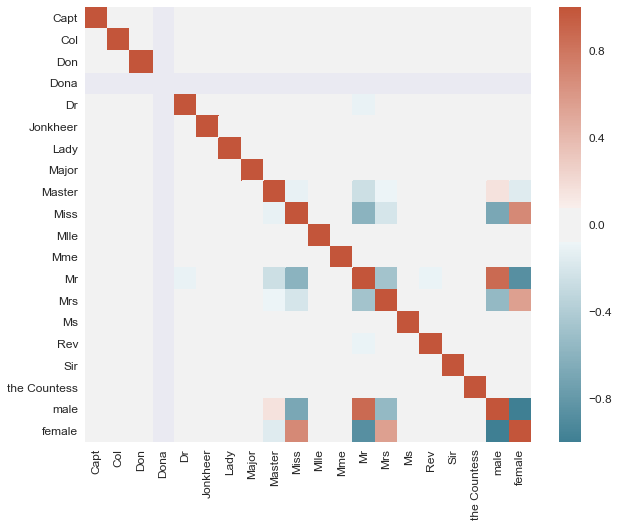

In [103]:
heatmap_feature = ['sex','Capt', 'Col', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major',
                   'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir', 'the Countess', 'male', 'female']

plt.figure(figsize=(10,8))

sns.set_context("notebook", font_scale=1.5, rc={"xtick.labelsize":12, "ytick.labelsize":12})

ax = sns.heatmap(df[df.data_type=='train'][heatmap_feature].corr(),
                 cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True),
                 center=0)

## pclass

This is the class of the passenger's ticket, and it looks like 3rd class passengers have the lowest survival rate. This may be due to where the passengers are located at the time of the accident: 1st class and 2nd class passengers most likely are located in the upper deck, meaning they have much faster access to the lifeboats, while 3rd class passengers are located in the lower deck, and the furthest away from the lifeboats.

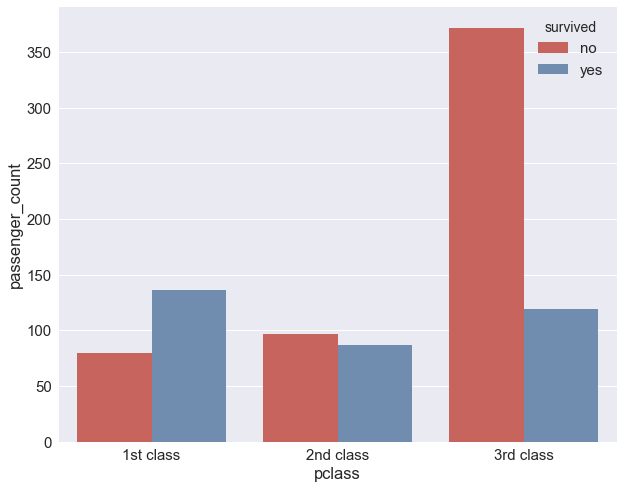

In [1110]:
pclass_df = eda_grouper('pclass', df)

pclass_df.pclass = pclass_df.pclass.apply(lambda r: '1st class' if r == 1 else ('2nd class' if r == 2 else '3rd class'))

#bar plot for sex and survive counts
plt.figure(figsize=(10,8))
sns.set(font_scale=1.5)
sns.barplot(x='pclass', y='passenger_count', hue='survived', data=pclass_df, palette=['#d9544d', '#658cbb'])

Even though the pclass variable is represented numerically, we need to dummify it, since this is an ordinal variable, which is considered a type of categorical variable.

In [104]:
#dummify the pclass since this is an ordinal variable
df = df.join(pd.get_dummies(df.pclass, prefix='pclass'))

#drop pclass
#train_df.drop('pclass', axis=1, inplace=True)

## cabin

One thing to note is that the cabin has an alphabetical prefix, which may be tied to where the cabin is located within the ship. The Titanic hit the iceberg at around midnight and sunk at around 2:00 AM, so most passenger are most likely asleep in their cabins. The cabin location therefore may be important, since some cabins may be closer to lifeboats than others. In addition blank cabin variables will be filled in with 'unknown'

In [105]:
df.cabin.fillna('UNKNOWN', inplace=True)

In [106]:
#grab the first letter of cabin designation
df['cabin_location'] = df.cabin.str[0]

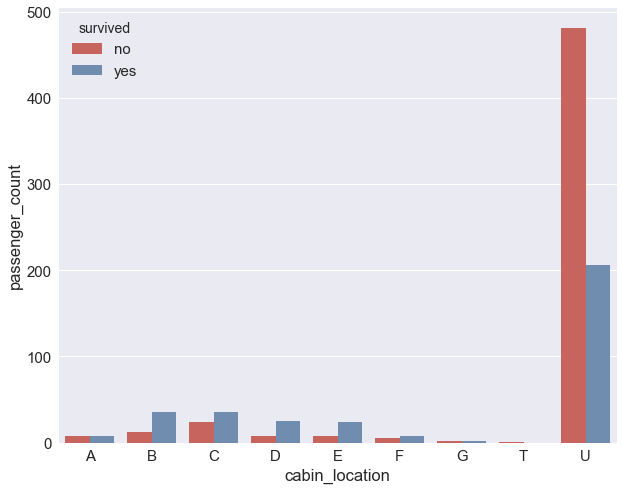

In [107]:
cabin_df = eda_grouper('cabin_location', df)

#bar plot for sex and survive counts
plt.figure(figsize=(10,8))
sns.set(font_scale=1.5)
sns.barplot(x='cabin_location', y='passenger_count', hue='survived', data=cabin_df, palette=['#d9544d', '#658cbb'])

need to check for multicollinearity again.
* remove cabin_U
* remove pclass_3

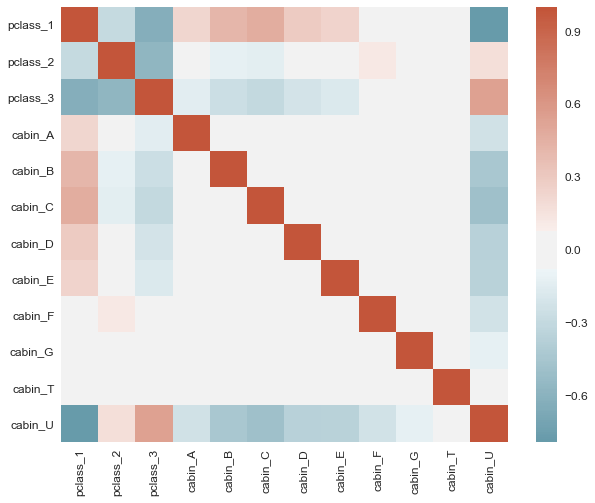

In [115]:
heatmap_feature = ['pclass_1', 'pclass_2', 'pclass_3', 'cabin_A', 'cabin_B', 'cabin_C',
                   'cabin_D', 'cabin_E', 'cabin_F', 'cabin_G', 'cabin_T', 'cabin_U']

plt.figure(figsize=(10,8))

sns.set_context("notebook", font_scale=1.5, rc={"xtick.labelsize":12, "ytick.labelsize":12})

ax = sns.heatmap(df[df.data_type=='train'][heatmap_feature].corr(),
                 cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True),
                 center=0)

In [114]:
df.columns

Index(['age', 'cabin', 'embarked', 'fare', 'name', 'parch', 'passengerid',
       'pclass', 'sex', 'sibsp', 'survived', 'ticket', 'data_type', 'title',
       'Capt', 'Col', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major',
       'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir',
       'the Countess', 'female', 'male', 'pclass_1', 'pclass_2', 'pclass_3',
       'cabin_location', 'cabin_A', 'cabin_B', 'cabin_C', 'cabin_D', 'cabin_E',
       'cabin_F', 'cabin_G', 'cabin_T', 'cabin_U'],
      dtype='object')

## parch

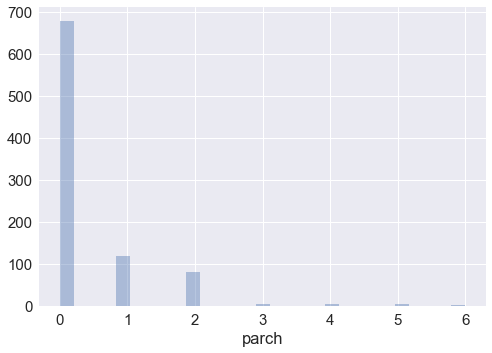

In [1123]:
sns.distplot(df[df.data_type=='train'].parch, kde=False, rug=False)

In [1066]:
df[df.data_type=='train'].parch.describe()

count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: parch, dtype: float64

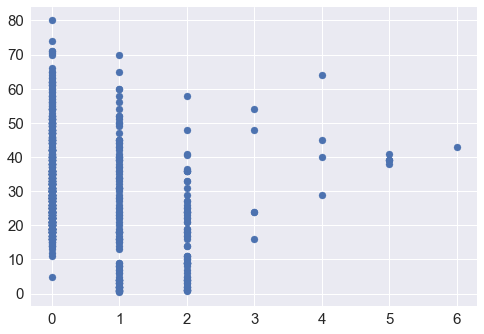

In [1067]:
plt.scatter(x=df[df.data_type=='train'].parch, y=df[df.data_type=='train'].age)

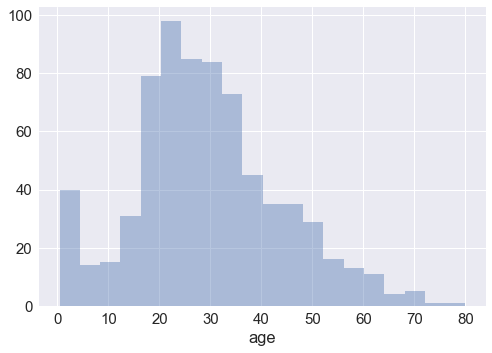

## sibsp

## fare

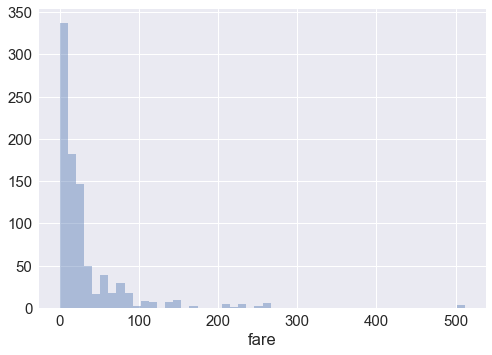

In [1124]:
sns.distplot(df[df.data_type=='train'].fare.dropna(), kde=False, rug=False)

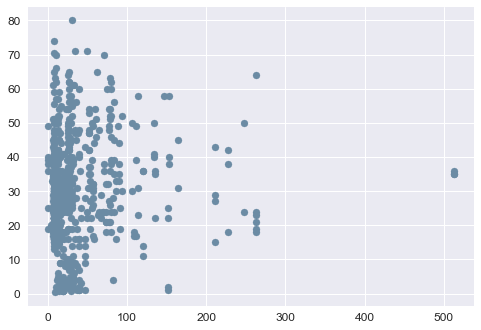

In [117]:
plt.scatter(x=df[df.data_type=='train'].fare, y=df[df.data_type=='train'].age, c="#6b8ba4")

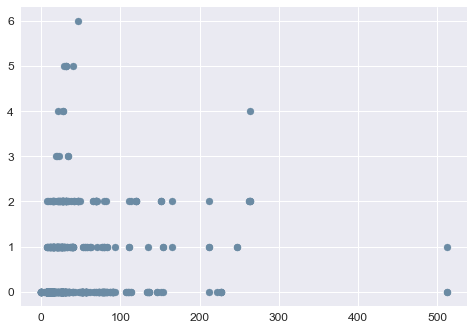

In [118]:
plt.scatter(x=df[df.data_type=='train'].fare, y=df[df.data_type=='train'].parch, c="#6b8ba4")

this might be a log relationship

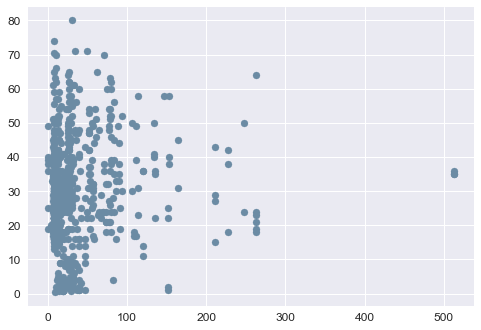

In [119]:
plt.scatter(x=df[df.data_type=='train'].fare, y=df[df.data_type=='train'].age, c="#6b8ba4")

## embarked

In [752]:
#dummify the pclass since this is an ordinal variable
df = df.join(pd.get_dummies(df.embarked, prefix='embarked'))

#drop pclass
#train_df.drop('pclass', axis=1, inplace=True)

In [753]:
df.columns

Index(['age', 'cabin', 'data_type', 'embarked', 'fare', 'name', 'parch',
       'passengerid', 'pclass', 'sex', 'sibsp', 'survived', 'ticket', 'title',
       'Capt', 'Col', 'Don', 'Dona', 'Dr', 'Jonkheer', 'Lady', 'Major',
       'Master', 'Miss', 'Mlle', 'Mme', 'Mr', 'Mrs', 'Ms', 'Rev', 'Sir',
       'female', 'male', 'pclass_1', 'pclass_2', 'pclass_3', 'cabin_location',
       'embarked_C', 'embarked_Q', 'embarked_S'],
      dtype='object')

## age

We have quite a few rows where age is missing, we'll use regression to fill in these NAs

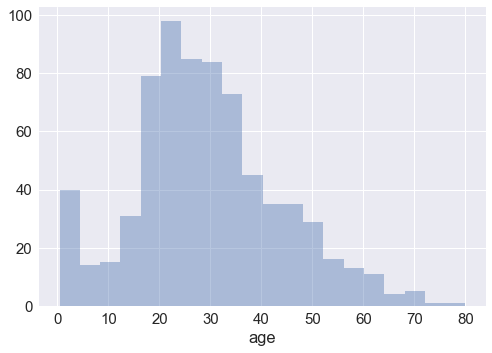

In [1125]:
sns.distplot(df[df.data_type=='train'].age.dropna(), kde=False, rug=False)

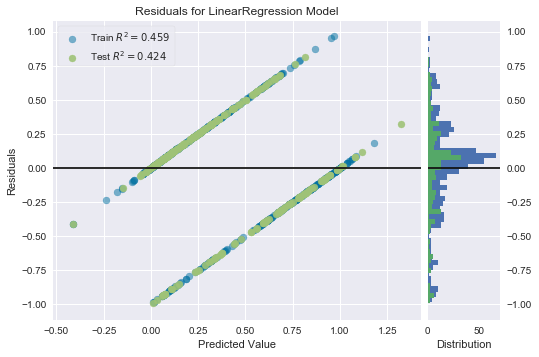

In [755]:
ols = linear_model.LinearRegression()
visualizer = ResidualsPlot(ols)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

In [756]:
train_df.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked', 'data_type'],
      dtype='object')

In [121]:
columns_drop = ['cabin',
                'embarked',
                'name',
                'passengerid',
                'pclass',
                'sex',
                'ticket',
                'cabin_location',
                'title',
                'female']

df.drop(columns_drop, axis=1, inplace=True)

# Multicollinearity

* There is perfect multicollinearity between `male` and `female`, so we need to exclude one of them from the model. For the purpose of this exercise we will be excluding the `male` variable.
* There is high degree of of multicollinearity between `female` and `Mr`, which makes sense since majority of the men have a `Mr` title, so we will need to exclude the `Mr` variable from the models.
* There is also a high degree of multicolinearity between `female` and `Miss`, most likely due to the majority of the women have a `Miss` title, so we will be excluding the `Miss` variable from the models.
* remove `cabin_U`
* remove `pclass_3`


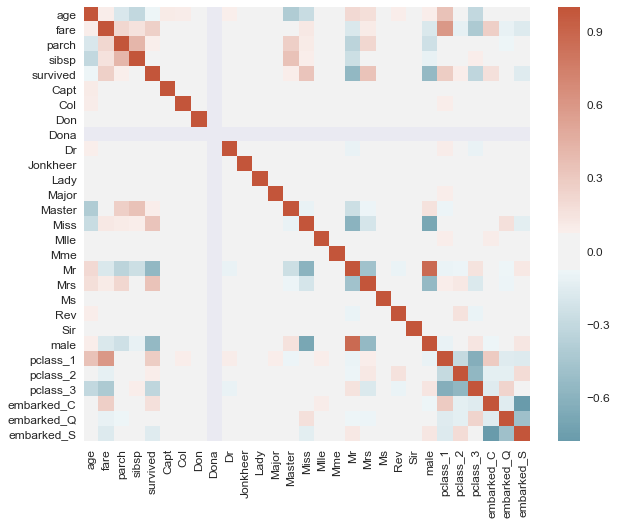

In [758]:
ax = sns.set_context("notebook", font_scale=1.5, rc={"xtick.labelsize":12, "ytick.labelsize":12})
ax = plt.figure(figsize=(10,8))
ax = sns.heatmap(df[df.data_type=='train'].corr(), cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True), center=0)

# Model 1 - Predicting Fare

# Multicollinearity

* There is perfect multicollinearity between `male` and `female`, so we need to exclude one of them from the model. For the purpose of this exercise we will be excluding the `male` variable.
* There is high degree of of multicollinearity between `female` and `Mr`, which makes sense since majority of the men have a `Mr` title, so we will need to exclude the `Mr` variable from the models.
* There is also a high degree of multicolinearity between `female` and `Miss`, most likely due to the majority of the women have a `Miss` title, so we will be excluding the `Miss` variable from the models.
* remove `cabin_U`
* remove `pclass_3`


In [145]:
fare_model_df = df.copy()
fare_model_df.dropna(inplace=True)

fare_feat = list(fare_model_df.columns)

for i in ['fare', 'survived', 'data_type', 'male', 'Mr', 'Miss', 'cabin_U', 'pclass_3']:
    fare_feat.remove(i)

X = fare_model_df[fare_feat]
y = fare_model_df['fare']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

#model fit on train data
fare_regression = linear_model.Lasso().fit(X_train, y_train)

#check for overfitting
print(fare_regression.score(X_train, y_train))
print(fare_regression.score(X_test, y_test))

0.4234032085958144
0.5137827187241748


In [759]:
fare_model_df = df.copy()
fare_model_df.dropna(inplace=True)

fare_feat = list(fare_model_df.columns)

for i in ['fare', 'survived', 'data_type']:
    fare_feat.remove(i)

X = fare_model_df[['pclass_1', 'male']]
y = fare_model_df['fare']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

#model fit on train data
fare_regression = linear_model.LinearRegression().fit(X_train, y_train)

#check for overfitting
print(fare_regression.score(X_train, y_train))
print(fare_regression.score(X_test, y_test))

0.3434483216309848
0.4364879001243893


In [149]:
#need to make a function out of this

#fill in nan fares
df.fare = df.apply(lambda r: float(fare_regression.predict(r[fare_feat].values.reshape(1,-1))) if np.isnan(r['fare']) 
         else r['fare'], axis=1)

# Model 2 - Predicting Age

In [761]:
linear_model.SGDRegressor()

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [159]:
len(X)

714

In [200]:
age_model_df = df.copy()
age_model_df.dropna(inplace=True)

age_feat = list(age_model_df.columns)

for i in ['age','survived', 'data_type']:
    age_feat.remove(i)
    
X = age_model_df[age_feat]
y = age_model_df['age']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2)

#model fit on train data
age_regression = linear_model.LinearRegression().fit(X_train, y_train)

#check for overfitting
print(age_regression.score(X_train, y_train))
print(age_regression.score(X_test, y_test))

0.43837301792556005
0.4102407027467879


In [201]:
df.age = df.apply(lambda r: float(age_regression.predict(r[age_feat].values.reshape(1,-1))) if np.isnan(r['age']) 
         else r['age'], axis=1)

## Variable Selection

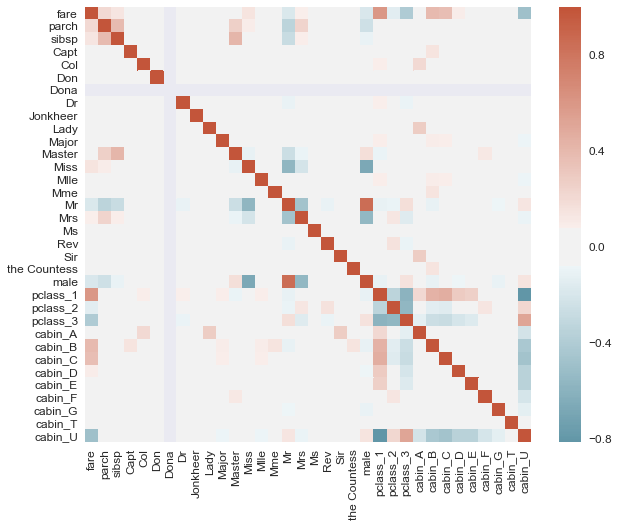

In [202]:
ax = sns.set_context("notebook", font_scale=1.5, rc={"xtick.labelsize":12, "ytick.labelsize":12})
ax = plt.figure(figsize=(10,8))
ax = sns.heatmap(X.corr(), cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True), center=0)

# Model 3 - Predicting Survivors

In [237]:
survived_features = list(df.columns)
drop_list = ['data_type', 'survived']

for i in drop_list:
    survived_features.remove(i)

X = df[df.data_type=='train'].dropna()[survived_features]
y = df[df.data_type=='train'].dropna()['survived']

In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

clf = RandomForestClassifier(max_features='sqrt')
clf = clf.fit(X_train, y_train)

In [239]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9727126805778491
0.8134328358208955


In [203]:
# select the f
survived_features = list(df.columns)
drop_list = ['data_type', 'survived', 'male', 'Mr', 'Miss', 'cabin_U', 'pclass_3']

for i in drop_list:
    survived_features.remove(i)

X = df[df.data_type=='train'].dropna()[survived_features]
y = df[df.data_type=='train'].dropna()['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)


#######
clf = RandomForestClassifier()

parameter_grid = {'max_depth' : [8,9,10,11],
                 'n_estimators': list(range(200,300,10)),
                 'criterion': ['gini','entropy'],
                 'class_weight': [None ,'balanced']}

grid_search = GridSearchCV(clf, parameter_grid)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [8, 9, 10, 11], 'n_estimators': [200, 210, 220, 230, 240, 250, 260, 270, 280, 290], 'criterion': ['gini', 'entropy'], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [206]:
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.8057784911717496
Best parameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 9, 'n_estimators': 230}


In [207]:
grid_search.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 9,
 'n_estimators': 230}

In [208]:
clf = RandomForestClassifier(grid_search.best_params_)

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)
clf = RandomForestClassifier(class_weight='balanced', criterion='gini', max_depth=9, n_estimators=230)
clf = clf.fit(X_train, y_train)

In [269]:
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.9213483146067416
0.835820895522388
